# Swap-Spread Trade

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

## Setup

The date is `Nov 4, 2008`.

**Treasury bond**
* Suppose the Treasury bond matures exactly `30` years later, on Nov 4, 2038.
* The YTM of this freshly issued treasury is `4.193\%` with a semiannual coupon of `4.50\%`.

**Swap**
* The fixed leg of the swap pays semiannually, with swap rate of `4.2560\%`.
* The floating leg of the swap also pays semiannually--not quarterly--such that the payment dates are identical on both legs. Thus, it also resets the floating rate semiannually, not quarterly.
* The floating rate of the swap equals the repo rate used in the trade. Thus, these two rates cancel in the financing of the trade.

***

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
def price_treasury_ytm(time_to_maturity, ytm, cpn_rate,freq=2,face=100):
    c = cpn_rate/freq
    y = ytm/freq
    
    rem = freq * (time_to_maturity % (1/freq))
    tau = freq * time_to_maturity - rem
    
    if round(tau)!=tau:
        print('warning')
    else:
        tau = round(tau)    
    
    pv = 0
    for i in range(1,tau):
        pv += 1 / (1+y)**i
    
    pv = c*pv + (1+c)/(1+y)**tau
    pv *= face
    
    if rem>0:
        pv += c*face
        pv /= (1+y)**rem
        
    return pv

In [3]:
def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

### Case Parameters

In [4]:
YTM = [0.04193, .0436]
CPNRATE = [0.0450, np.nan]    
SWAPRATE = [.042560, .0408]

TPRICE = 105
PAR = 100

NOTIONAL = 500e6
HAIRCUT = .02

DELTATIME = .5
tau0 = 30
tau1 = tau0-DELTATIME

SWAP_FACE = 100
# dummy variable to compare to floating, fixed

### Adjustments

Adjust the case parameters.

In [5]:
USE_CPN = True
USE_YTM = False
USE_PRICE = False

if not USE_CPN:
    CPNRATE[0] = YTM[0]

if USE_YTM and USE_PRICE:
    warning('Case YTM and Price are inconsistent; recalculating price')
    USE_PRICE = False

if not USE_YTM and not USE_PRICE:
    YTM[0] = CPNRATE[0]
    TPRICE = PAR

if USE_YTM and not USE_PRICE:
    TPRICE = price_treasury_ytm(tau0,YTM[0],CPNRATE[0])

if USE_PRICE and not USE_YTM:
    pv_wrapper = lambda y: TPRICE - price_treasury_ytm(tau0,y,CPNRATE[0])    
    YTM[0] = fsolve(pv_wrapper,.04)[0]

#### Specify Trade Size

Pinning down notional swap position, Tbond face value, or Tbond market value?

In [6]:
SET_SIZE = 'swap'

### Market environment

In [7]:
TPRICE_1 = price_treasury_ytm(tau1,YTM[1],CPNRATE[0])

summary = pd.DataFrame(index=['coupon rate','price','YTM','swap rate'],columns = ['Nov 2008','May 2009'],dtype=float)
summary.loc['coupon rate'] = CPNRATE
summary.loc['price'] = [TPRICE, TPRICE_1]
summary.loc['YTM'] = YTM
summary.loc['swap rate'] = SWAPRATE
summary.loc['spread'] = summary.loc['swap rate'] - summary.loc['YTM']
#summary.loc['coupon spread'] = summary.loc['swap rate'] - summary.loc['coupon rate']

summary.T.iloc[[0],:].style.format({'price':'{:.2f}', 'coupon rate':'{:.2%}', 'YTM':'{:.2%}', 'swap rate':'{:.2%}', 'spread':'{:.2%}'})

,coupon rate,price,YTM,swap rate,spread
Nov 2008,4.50%,100.00,4.50%,4.26%,-0.24%


# Cashflows

In [8]:
SOFR = np.nan

In [9]:
CF = pd.DataFrame(index=['T bond','Repo','Swap (floating leg)','Swap (fixed leg)'],columns=['May 2009'],dtype=float)
CF.loc['Repo'] -SOFR
CF.loc['Swap (floating leg)'] = SOFR
CF.loc[['T bond']] = PAR * CPNRATE[0] /2
CF.loc[['Swap (fixed leg)']] = -PAR * SWAPRATE[0]/2
CF.loc['Net Payment'] = CF.sum(axis=0)
CF.style.format('${:,.2f}')

,May 2009
T bond,$2.25
Repo,$nan
Swap (floating leg),$nan
Swap (fixed leg),$-2.13
Net Payment,$0.12


#### SOFR rate cancels

No need to account for the repo rate or the swap's floating payment, as they both are modeled in this problem with SOFR, and thus net to zero.

# Duration

In [10]:
tab_duration = pd.DataFrame(dtype=float, index=['T bond','fixed leg', 'floating leg'], columns=['duration'])
tab_duration.loc['T bond'] = duration_closed_formula(tau0, summary.loc['YTM','Nov 2008'], summary.loc['coupon rate','Nov 2008'])
tab_duration.loc['fixed leg'] = duration_closed_formula(tau0, summary.loc['swap rate','Nov 2008'])
tab_duration.loc['floating leg'] = .5
tab_duration.loc['repo'] = .5

tab_duration['dollar duration'] = tab_duration['duration'] * np.array([TPRICE, PAR, PAR, TPRICE * (1-HAIRCUT)])

tab_net = pd.DataFrame(dtype=float, index=['T bond repo','swap'], columns=['duration','dollar duration'])
tab_net.loc['T bond repo'] = tab_duration.loc['T bond'] - tab_duration.loc['repo']
tab_net.loc['swap'] = tab_duration.loc['fixed leg'] - tab_duration.loc['floating leg']
tab_net.loc['net'] = tab_net.loc['T bond repo'] - tab_net.loc['swap']

display(tab_duration)

display(tab_net)

,duration,dollar duration
T bond,16.742902,1674.290214
fixed leg,17.212744,1721.274445
floating leg,0.500000,50.000000
repo,0.500000,49.000000


,duration,dollar duration
T bond repo,16.242902,1625.290214
swap,16.712744,1671.274445
net,-0.469842,-45.984231


Match dollar duration by ensuring that the ratio of contracts equals the ratio of dollar duration:

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

In [11]:
hedge_ratio = -tab_net.loc['swap','dollar duration'] / tab_net.loc['T bond repo','dollar duration']

if SET_SIZE == 'Tbond face':
    notional_tbond = NOTIONAL * TPRICE / PAR    
elif SET_SIZE == 'Tbond value':
    notional_tbond = NOTIONAL
elif SET_SIZE == 'swap':
    notional_tbond = -NOTIONAL * hedge_ratio
else:
    warning('Sizing is not specified; fixing swap notional')
    notional_tbond = -NOTIONAL * hedge_ratio

notional_swaps = notional_tbond * (1/hedge_ratio)
n_tbonds = notional_tbond / TPRICE
n_swaps = notional_swaps / SWAP_FACE

contracts = pd.DataFrame(np.array([n_tbonds, n_swaps]), index=['T bond repo','swap'], columns=['positions'])
contracts

,positions
T bond repo,5.141465e+06
swap,-5.000000e+06


# May 2009

In [12]:
summary.T.style.format({'price':'{:.2f}', 'coupon rate':'{:.2%}', 'YTM':'{:.2%}', 'swap rate':'{:.2%}', 'spread':'{:.2%}'})

,coupon rate,price,YTM,swap rate,spread
Nov 2008,4.50%,100.00,4.50%,4.26%,-0.24%
May 2009,nan%,102.31,4.36%,4.08%,-0.28%


In [13]:
prices = pd.DataFrame(index=['T bond', 'swap'],dtype=float,columns=['Nov 2008'])

prices.loc['T bond','Nov 2008'] = TPRICE
prices.loc['swap','Nov 2008'] = 0

prices.loc['T bond','May 2009'] = TPRICE_1
prices.loc['swap','May 2009'] = price_treasury_ytm(tau1, summary.loc['swap rate','May 2009'], summary.loc['swap rate','Nov 2008']) - PAR

prices.T.style.format('${:,.2f}')

,T bond,swap
Nov 2008,$100.00,$0.00
May 2009,$102.31,$3.00


The rising YTM on the T bond suggests...
* lower (adjusted) price for the T-bond.
* we are long the T-bond, so this would be a loss.

The lower swap rate suggests...
* higher value on the fixed leg of a swap.
* we are paying fixed, (ie short the fixed leg), so this would again be a loss.

The floating leg of the swap and repo rate cancel.

In [14]:
pnl=pd.DataFrame(dtype=float,index=['T bond','swap'],columns=['cashflow'])

pnl['cashflow'] = CF.loc[['T bond','Swap (fixed leg)']].values * contracts.abs().values
pnl['capital gains'] = prices.diff(axis=1)['May 2009'].values * contracts.values[:,0]

pnl.loc['net'] = pnl.sum()

pnl['total'] = pnl.sum(axis=1)

pnl.style.format('${:,.2f}',na_rep='')

,cashflow,capital gains,total
T bond,"$11,568,295.52","$11,883,984.99","$23,452,280.51"
swap,"$-10,640,000.00","$-15,016,747.03","$-25,656,747.03"
net,"$928,295.52","$-3,132,762.04","$-2,204,466.52"


In [15]:
capital = pd.DataFrame(prices.iloc[:,0].values * contracts.values[:,0], index=['T bond','swap'],columns=['assets'])
capital['equity'] = capital['assets'] * HAIRCUT
capital.loc['net'] = capital.sum()

capital['pnl'] = pnl['total']
capital['return'] = capital['pnl']/capital['equity']
capital.loc[['T bond','swap'],'return'] = np.nan

capital.style.format({'assets':'${:,.2f}','equity':'${:,.2f}','pnl':'${:,.2f}','return':'{:.2%}'},na_rep='')

,assets,equity,pnl,return
T bond,"$514,146,467.68","$10,282,929.35","$23,452,280.51",
swap,$-0.00,$-0.00,"$-25,656,747.03",
net,"$514,146,467.68","$10,282,929.35","$-2,204,466.52",-21.44%


***

# Swap Spread Since The Great Financial Crisis

In [16]:
filepath = '../data/sofr_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'

swaps_sofr = swaps_raw.copy()

In [17]:
filepath = '../data/libor_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'

swaps_libor = swaps_raw.copy()

In [18]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

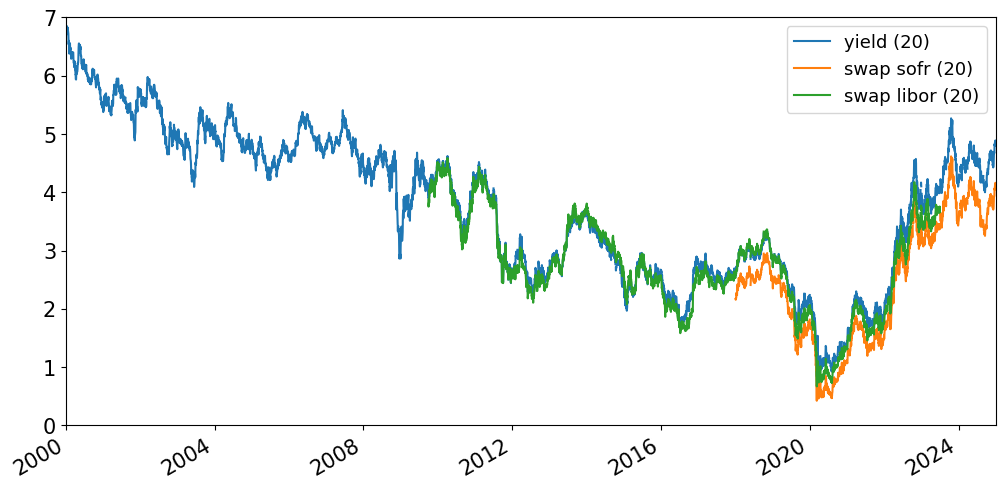

In [19]:
idx = 20
tab = pd.concat([yields[idx],swaps_sofr[idx],swaps_libor[idx]],axis=1)
tab.columns = [f'yield ({idx})',f'swap sofr ({idx})',f'swap libor ({idx})']
tab.plot(xlim=('2000','2025'),ylim=(0,7));

Take the mean of the libor and sofr swaps for dates where both exist.

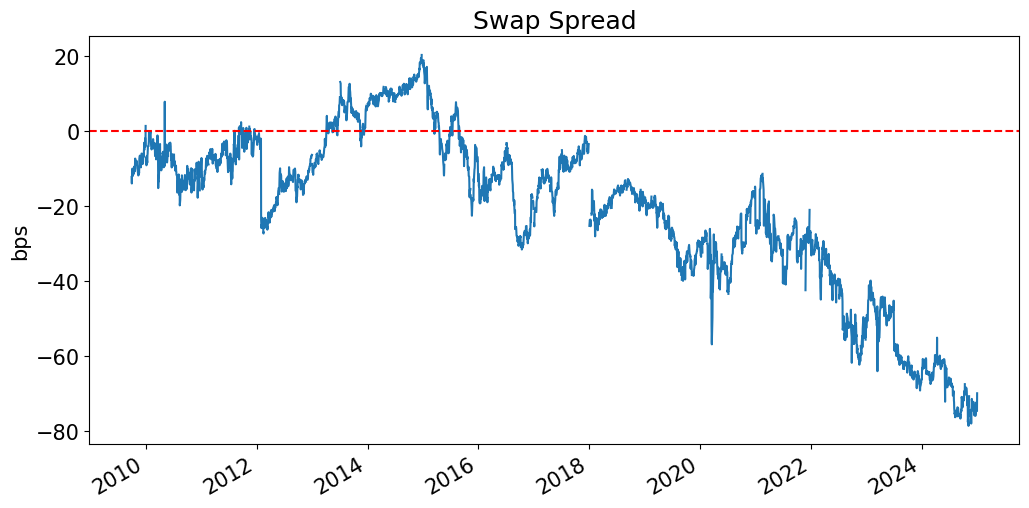

In [20]:
tab['swap spread'] = tab.iloc[:,[1,2]].mean(axis=1)-tab.iloc[:,0]
(tab['swap spread']*100).plot(title='Swap Spread',ylabel='bps')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

***

## Pricing in Nov 2023

In [21]:
ytm2023 = yields.loc['2023-11-03',[10,20]].mean()/100
prices.loc['T bond','Nov 2023'] = price_treasury_ytm(15,ytm2023,CPNRATE[0])

swaprate2023 = swaps_sofr.loc['2023-11-03',15]/100
prices.loc['swap','Nov 2023'] = price_treasury_ytm(15,swaprate2023,SWAPRATE[0]) - PAR

In [22]:
summary['Nov 2023'] = [np.nan, prices.loc['T bond','Nov 2023'], ytm2023, swaprate2023, np.nan]
summary.loc['spread','Nov 2023'] = summary.loc['swap rate','Nov 2023'] - summary.loc['YTM','Nov 2023']
summary.T.style.format({'price':'{:.2f}', 'coupon rate':'{:.2%}', 'YTM':'{:.2%}', 'swap rate':'{:.2%}', 'spread':'{:.2%}'})
#summary.T.style.format({'coupon rate':'{:.2%}','YTM':'{:.2%}','swap rate':'{:.2%}','spread':'{:.2%}','price':'{:.2f}'})

,coupon rate,price,YTM,swap rate,spread
Nov 2008,4.50%,100.00,4.50%,4.26%,-0.24%
May 2009,nan%,102.31,4.36%,4.08%,-0.28%
Nov 2023,nan%,97.76,4.71%,4.27%,-0.44%


In [23]:
pnl_2023 = pd.DataFrame(index=pnl.index,columns=pnl.columns,dtype=float)
pnl_2023['cashflow'] = pnl.loc[['T bond','swap'],'cashflow'] * 15 * 2
pxchange = prices['Nov 2023'] - prices['Nov 2008']
pnl_2023.loc[['T bond','swap'],'capital gains'] = pxchange.values * contracts.squeeze().values
pnl_2023['total'] = pnl_2023.sum(axis=1)
pnl_2023.loc['net'] = pnl_2023.sum(axis=0)
pnl_2023.style.format('${:,.0f}').set_caption('Perfromance from Nov 2008 to Nov 2023')

,cashflow,capital gains,total
T bond,"$347,048,866","$-11,496,054","$335,552,812"
swap,"$-319,200,000","$934,224","$-318,265,776"
net,"$27,848,866","$-10,561,830","$17,287,036"
